In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from Unet.metrics import dice_coff
import os
import random
from skimage.io import imread
from Unet.rle import masks_as_image

In [2]:
def make_image_ds(in_df, batch_size=32, image_dir='../train_v2', IMG_SCALING=None):
    """
    
    :param IMG_SCALING: Reducing image shape
    :param image_dir: directory that contains images
    :param in_df: Pandas DataFrame where paths to the images and encoded ground truth labels are stored
    :param batch_size: Batch size of created tf.data.Dataset
    :return: returns tf.data.Dataset created from generator
    """
    all_batches = list(in_df.groupby('ImageId'))
    
    img_list = []
    mask_list = []

    np.random.shuffle(all_batches)
    for c_img_id, c_masks in all_batches:
        rgb_path = os.path.join(image_dir, c_img_id)
        c_img = imread(rgb_path)
        c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
                
        if IMG_SCALING is not None:
            c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
            c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
        
        img_list.append(c_img/255.0)
        mask_list.append(c_mask)
    
    
    images = np.stack(img_list, axis=0, dtype=np.float32) # Creates numpy array of shape (number of unique images, 256, 256, 3)
    masks = np.stack(mask_list, axis=0) # Creates numpy array of shape (number of unique images, 256, 256, 3)

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


In [3]:
def preprocess(path, img_scaling=None):
    img = imread(path)
    
    if img_scaling is not None:
            img = img[::img_scaling[0], ::img_scaling[1]]
        
    return img/255.0

In [6]:
def see_results(images_folder='../test_v2', threshold=0.5):
    model = tf.keras.models.load_model('model.h5', custom_objects={"dice_coff": dice_coff})
    
    random_images = [random.choice(os.listdir(images_folder)) for _ in range(3)]
    
    plt.figure(figsize=(10,12))
    
    plt.subplot(3, 2, 1)
    plt.grid(False)  
    img = preprocess(os.path.join(images_folder, random_images[0]), (3, 3))
    plt.imshow(img)
    
    plt.subplot(3, 2, 2)
    plt.grid(False)
    prediction = model.predict(img[np.newaxis, :])
    prediction = np.where(prediction > threshold, 1, 0)
    plt.imshow(np.squeeze(prediction))
    
    
    plt.subplot(3, 2, 3)
    plt.grid(False)  
    img = preprocess(os.path.join(images_folder, random_images[1]), (3, 3))
    plt.imshow(img)
    
    plt.subplot(3, 2, 4)
    plt.grid(False)
    prediction = model.predict(img[np.newaxis, :])
    prediction = np.where(prediction > threshold, 1, 0)
    plt.imshow(np.squeeze(prediction))
    
    
    plt.subplot(3, 2, 5)
    plt.grid(False)  
    img = preprocess(os.path.join(images_folder, random_images[2]), (3, 3))
    plt.imshow(img)
    
    plt.subplot(3, 2, 6)
    plt.grid(False)
    prediction = model.predict(img[np.newaxis, :])
    prediction = np.where(prediction > threshold, 1, 0)
    plt.imshow(np.squeeze(prediction))
    
    plt.show()

1/1 [==============================] - 0s 47ms/step


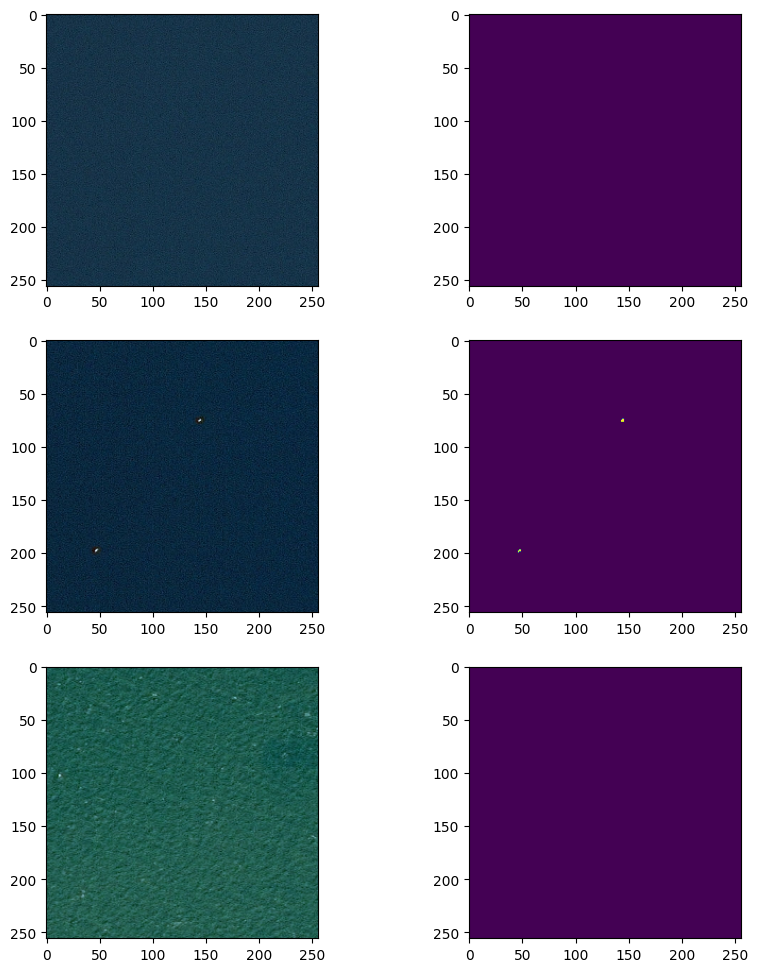

In [11]:
see_results()

In [4]:
validation_df = pd.read_csv('../valid_df.csv')

In [5]:
ds = make_image_ds(in_df=validation_df, IMG_SCALING=(3, 3))

In [7]:
model = tf.keras.models.load_model('model.h5', custom_objects={"dice_coff": dice_coff})
coeff = model.evaluate(ds)[1]

C:\Users\glebl\PycharmProjects\Airbus-Ship-Detection-Challenge\test_ai\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


80/80 [==============================] - 20s 239ms/step - loss: 0.0014 - dice_coff: 0.6943


In [8]:
print(f'Dice coefficient of validation dataset is {coeff}')

Dice coefficient of validation dataset is 0.6942723989486694
